In [ ]:
# hide
# skip
!git clone https://github.com/benihime91/gale # install gale on colab
!pip install -e "gale[dev]"

In [ ]:
# default_exp classification.task

In [ ]:
# hide
%load_ext nb_black
%load_ext autoreload
%autoreload 2
%matplotlib inline

<IPython.core.display.Javascript object>

In [ ]:
# hide
import warnings

from nbdev.export import *
from nbdev.showdoc import *

warnings.filterwarnings("ignore")

<IPython.core.display.Javascript object>

# Classification Task
> Lightning Image Classification Task

In [ ]:
# export
import logging
from typing import *

import numpy as np
import pytorch_lightning as pl
import torch
import torch.nn.functional as F
import torchmetrics
from fastcore.all import *
from omegaconf import DictConfig, ListConfig, OmegaConf
from timm.data.mixup import Mixup, mixup_target
from torch import nn

from gale.classification.data import (
    build_classification_loader_from_config,
    cifar_stats,
    imagenet_stats,
    mnist_stats,
    show_image_batch,
)
from gale.classification.modelling import build_model
from gale.core.classes import GaleTask, GaleModule
from gale.core.nn.losses import build_loss
from gale.core.nn.utils import trainable_params

logger = logging.getLogger(__name__)

<IPython.core.display.Javascript object>

In [ ]:
# export
# hide
# fmt: off
class Mixup(Mixup):
    """
    CPU friendly Mixup from timm
    """
    def __call__(self, x, target):
        assert len(x) % 2 == 0, 'Batch size should be even when using this'
        if self.mode == 'elem':
            lam = self._mix_elem(x)
        elif self.mode == 'pair':
            lam = self._mix_pair(x)
        else:
            lam = self._mix_batch(x)
        target = mixup_target(target, self.num_classes, lam, self.label_smoothing, device=x.device)
        return x, target
# fmt: on

<IPython.core.display.Javascript object>

In [ ]:
# export
class ClassificationTask(GaleTask):
    is_restored = True
    """
    A General PyTorch Lightning Task for Image Classification

    Arguments:
    1. cfg: gale default config.
    2. trainer (Optional): Pytorch Lightning Trainer instance
    2. metrics (Optional): A List of `torchmetrics` used during training.
    """

    def __init__(
        self,
        cfg: DictConfig,
        trainer: pl.Trainer = None,
        metrics: Union[torchmetrics.Metric, Mapping, Sequence, None] = None,
    ):
        super(ClassificationTask, self).__init__(
            cfg=cfg, trainer=trainer, metrics=metrics
        )
        # Train Loss is used for the Training Dataset
        self.train_loss = noop
        # Eval Loss is used for Validation / Test Datasets
        self.eval_loss = noop

    def setup(self, stage: Optional[str] = None):
        # that means model has not been build manually
        # so we need to build it
        if self._model is noop:
            self.setup_model()

        # if the trainer is passed, that means we are in training
        # so we need to setup the train_dataloaders, valid_dataloaders (Optional)
        # test_dataloaders (Optional) and the optimziation for ht emodel
        if not self.is_restored:
            if self._train_dl is noop:
                self.setup_training_data()
            if self._validation_dl is noop:
                self.setup_validation_data()
            if self._test_dl is noop:
                self.setup_test_data()
            if self._optimizer is noop and self._scheduler is noop:
                optim = self.process_optim_config(self._cfg.optimization)
                self.setup_optimization(optim)

            # setup mixup/cutmix for the model
            mixup_args = self._cfg.training.mixup.init_args
            self.mixup_off_epoch = self._cfg.training.mixup.off_epoch
            self.mixup_fn = Mixup(**mixup_args)

            # build up the loss functions
            self.train_loss = build_loss(self._cfg.training.train_loss_fn)
            self.eval_loss = build_loss(self._cfg.training.eval_loss_fn)

            shapes = (
                self._cfg.input.channels,
                self._cfg.input.height,
                self._cfg.input.width,
            )
            self.example_input_array = torch.randn(1, *shapes)
        else:
            pass

    def forward(self, x):
        """
        Forward method: we pass in the input through the meta_arch
        to get the predictions for the current image batch
        """
        return self._model(x)

    def shared_step(self, batch: Any, batch_idx: int, stage: str) -> Dict:
        stages = ["train", "validation", "test"]
        assert stage in stages

        # Check wether Mixup Threshold is reached and stop mixup
        # makes no sense to check in other stages; so check in
        # the training stage
        if stage == "train":
            if self.mixup_off_epoch and self.current_epoch >= self.mixup_off_epoch:
                self.mixup_fn.mixup_enabled = False

        # Unpack Batch
        x, y = batch

        # Apply mixup in the training stage
        if stage == "train":
            # NOTE: This converts the targets into 1 hot vectores
            x, y_mix = self.mixup_fn(x, y)

        # calculate the logits
        y_hat = self(x)

        # Comput Loss
        if stage == "train":
            loss = self.train_loss(y_hat, y_mix)
        else:
            loss = self.eval_loss(y_hat, y)

        # compute probas
        y_hat = F.softmax(y_hat)

        logs = {}
        logs["loss"] = loss

        for name, metric in self.metrics.items():
            if isinstance(metric, torchmetrics.metric.Metric):
                metric(y_hat, y)
                logs[name] = metric
            else:
                logs[name] = metric(y_hat, y)

        output = dict(loss=loss, logs=logs)
        return output

    def setup_model(self, args: DictConfig = None):
        """
        Builds up the meta architecture. You can also additionally pass in args to configure
        from a config other than the orignal one.
        """
        conf = ifnone(args, self._cfg)
        meta_arch = build_model(conf)
        self._model = meta_arch

    @property
    def param_dicts(self):
        """Returns the paramters for model optimization"""
        return (
            self._model.build_param_dicts()
            if self._model is not noop
            else trainable_params(self)
        )

    def setup_training_data(self, name: str = None, dls_conf: DictConfig = None):
        """
        Builds the training dataset from name and the dataloader from `dls_conf`, if
        None then parsers the values from the passed config while creating the instance
        """
        name = ifnone(name, self._cfg.datasets.train)
        conf = ifnone(dls_conf, self._cfg.dataloader.train)
        self._train_dl = build_classification_loader_from_config(name, conf)

    def setup_validation_data(
        self, name: Union[List, str] = None, dls_conf: DictConfig = None
    ):
        """Same as `setup_training_data` but sets up validation dataset and dataloaders"""
        name = ifnone(name, self._cfg.datasets.valid)
        conf = ifnone(dls_conf, self._cfg.dataloader.valid)

        # if name is still none , that means no validation data
        if name is None:
            self._validation_dl = None
        else:
            if isinstance(name, list) or isinstance(name, ListConfig):
                names = list(name)
                dls = [build_classification_loader_from_config(n, conf) for n in names]
            elif isinstance(name, str):
                dls = build_classification_loader_from_config(name, conf)
            else:
                logger.warning(
                    "Validation dataset name format not understood. Must either be str or List."
                )
                dls = None
            self._validation_dl = dls

    def setup_test_data(
        self, name: Union[List, str] = None, dls_conf: DictConfig = None
    ):
        """Same as `setup_training_data` but sets up test dataset and dataloaders"""
        name = ifnone(name, self._cfg.datasets.test)
        conf = ifnone(dls_conf, self._cfg.dataloader.test)

        # if name is still none , that means no validation data
        if name is None:
            self._test_dl = None
        else:
            if isinstance(name, list) or isinstance(name, ListConfig):
                names = list(name)
                dls = [build_classification_loader_from_config(n, conf) for n in names]
            elif isinstance(name, str):
                dls = build_classification_loader_from_config(name, conf)
            else:
                logger.warning(
                    "Test dataset name format not understood. Must either be str or List"
                )
                dls = None
            self._test_dl = dls

    def test_dataloader(self):
        self.setup_test_data()
        if self._test_dl is None or self._test_dl is noop:
            return None
        else:
            return self._test_dl

    @use_kwargs_dict(keep=True, n=8, nrows=2, ncols=4, figsize=None, imsize=3)
    def show_batch(self, prefix: str = "train", **kwargs):
        """Displays a batch from a dataloader defined by prefix"""
        if self._train_dl is noop:
            self.setup()

        if prefix == "train":
            loader = [self._train_dl]

        elif prefix == "validation":
            loader = self._validation_dl

        elif prefix == "test":
            loader = self._test_dl
        else:
            raise ValueError("Unkonwn stage must be train, validation or test")

        if loader is None:
            logger.warning(f"No Dataset and DataLoader provied for {prefix} stage")
            logger.info("Skipping show batch")
            return
        else:
            # DataLoaders can either be List or DataLoader
            try:
                loader = loader[0]
            except:
                pass

        inputs, classes = next(iter(loader))

        if prefix == "train":
            inputs, _ = self.mixup_fn(inputs, classes)

        if self._cfg.input.mean == "imagenet":
            mean, std = imagenet_stats
        elif self._cfg.input.mean == "cifar":
            mean, std = cifar_stats
        elif self._cfg.input.mean == "mnist":
            mean, std = mnist_stats
        else:
            mean, std = np.array(self._cfg.input.mean), np.array(self._cfg.input.std)

        mean = torch.tensor(np.array(mean)).float()
        std = torch.tensor(np.array(std)).float()

        batch = (inputs, classes)

        show_image_batch(batch, mean=mean, std=std, **kwargs)

    @property
    def model(self):
        return self._model

    @model.setter
    def model(self, m: GaleModule):
        assert isinstance(m, GaleModule)
        self._model = m

<IPython.core.display.Javascript object>

In [ ]:
# fmt: off
from fastcore.all import Path
from nbdev.export import Config

from gale.classification.data import register_dataset_from_folders
from gale.classification.data.transforms import (imagenet_augment_transform,
                                                 imagenet_no_augment_transform)
from gale.collections.callbacks import NotebookProgressCallback
from gale.collections.download import download_and_extract_archive
from gale.config import get_config
from gale.core.utils.logger import setup_logger

setup_logger(level=logging.INFO)

URL = "https://download.pytorch.org/tutorial/hymenoptera_data.zip"
data_path = Path(Config().path("nbs_path")) / "data"

# download a toy dataset
download_and_extract_archive(url=URL, download_root=data_path, extract_root=data_path)

Using downloaded and verified file: /Users/ayushman/Desktop/gale/nbs/data/hymenoptera_data.zip
Extracting /Users/ayushman/Desktop/gale/nbs/data/hymenoptera_data.zip to /Users/ayushman/Desktop/gale/nbs/data


<IPython.core.display.Javascript object>

In [ ]:
# train data is present in :
train_data = data_path / "hymenoptera_data/train"
val_data = data_path / "hymenoptera_data/val"

# Register Datasets :
register_dataset_from_folders(
    name="hymenoptera_train",
    image_root=train_data,
    augmentations=imagenet_augment_transform(224),
)

register_dataset_from_folders(
    name="hymenoptera_valid",
    image_root=val_data,
    augmentations=imagenet_no_augment_transform(224),
)

[04/27 15:37:20 gale.classification.data.build]: Dataset: hymenoptera_train registerd to DatasetCatalog
[04/27 15:37:20 gale.classification.data.build]: Dataset: hymenoptera_valid registerd to DatasetCatalog


<IPython.core.display.Javascript object>

In [ ]:
# Create or Update the Gale default Config :
# we can also specify overrides using the api of HYDRA
overrides = [
    "head@model.head=classification/fc_head",  # this modifies the head of the model
    "optimizer=sgd",  # this modifies the optimizer
    "scheduler=warm_step",  # this modifies the scheduler in the optimizer
]

cfg = get_config("classification", overrides=overrides)

# input arguments
cfg.input.channels = 3
cfg.input.height = 224
cfg.input.width = 224

# model arguments
cfg.model.num_classes = 2

cfg.model.backbone.init_args.model_name = "resnet18"
cfg.model.backbone.init_args.pretrained = True
cfg.model.backbone.init_args.freeze_at = 2
cfg.model.backbone.init_args.lr = 1e-04
cfg.model.backbone.init_args.wd = 1e-05

cfg.model.head.init_args.num_classes = "${model.num_classes}"
cfg.model.head.init_args.filter_wd = True
cfg.model.head.init_args.drop_rate = 0.3
cfg.model.head.init_args.lr = 1e-02
cfg.model.head.init_args.wd = 1e-05

# datasets
cfg.datasets.train = "hymenoptera_train"
cfg.datasets.valid = "hymenoptera_valid"
cfg.datasets.test = "hymenoptera_valid"

# optimization
cfg.optimization.optimizer.init_args.momentum = 0.9
cfg.optimization.optimizer.init_args.weight_decay = 1e-05

cfg.optimization.scheduler.init_args.epochs = 20
cfg.optimization.scheduler.init_args.warmup_epochs = 3
cfg.optimization.scheduler.init_args.num_decays = 3

# setup mixup:
cfg.training.mixup.off_epoch = False
# This sets mixup/cutmix to be false during training
cfg.training.mixup.init_args.prob = 0.0
# cfg.training.mixup.init_args.mixup_alpha = 0.4
# cfg.training.mixup.init_args.cutmix_alpha = 1.0
# cfg.training.mixup.init_args.label_smoothing = 0.0

<IPython.core.display.Javascript object>

In [ ]:
# collapse-output
print(OmegaConf.to_yaml(cfg))

training:
  train_loss_fn:
    name: SoftTargetCrossEntropy
    init_args: null
  eval_loss_fn:
    name: CrossEntropyLoss
    init_args:
      weight: null
      size_average: null
      ignore_index: -100
      reduce: None
      reduction: mean
  mixup:
    off_epoch: false
    init_args:
      mixup_alpha: 0.4
      cutmix_alpha: 1.0
      cutmix_minmax: null
      prob: 0.0
      switch_prob: 0.5
      mode: batch
      correct_lam: true
      label_smoothing: 0.0
      num_classes: ${model.num_classes}
model:
  meta_architecture:
    name: GeneralizedImageClassifier
    init_args: null
  backbone:
    name: ResNetBackbone
    init_args:
      model_name: resnet18
      act: null
      lr: 0.0001
      wd: 1.0e-05
      lr_div: 10
      freeze_at: 2
      pretrained: true
      drop_block_rate: null
      drop_path_rate: null
      bn_tf: false
  head:
    name: FullyConnectedHead
    init_args:
      num_classes: ${model.num_classes}
      pool_type: avg
      drop_rate: 0.3
    

<IPython.core.display.Javascript object>

In [ ]:
# slow
cbs = [
    NotebookProgressCallback(),
    pl.callbacks.LearningRateMonitor(log_momentum=True),
]

logger = pl.loggers.TensorBoardLogger(
    save_dir="lightning_logs/", name="task", log_graph=True, default_hp_metric=False
)

# Initialize the pytorch-lightning trainer with all its goodies
trainer = pl.Trainer(max_epochs=20, callbacks=cbs, log_every_n_steps=1, logger=logger)

# Initialize out LightningModule
task = ClassificationTask(cfg, trainer, metrics=torchmetrics.Accuracy())

GPU available: False, used: False
TPU available: False, using: 0 TPU cores


<IPython.core.display.Javascript object>

[04/27 16:01:04 gale.classification.modelling.meta_arch.build]: Building GeneralizedImageClassifier from config ...
[04/27 16:01:05 gale.classification.modelling.meta_arch.common]: Model created, param count: 11.2 M.


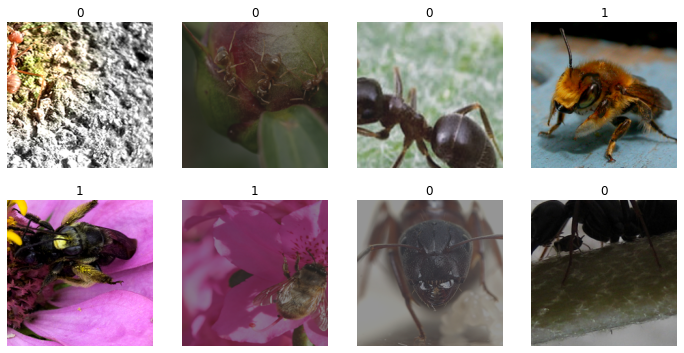

<IPython.core.display.Javascript object>

In [ ]:
# slow
# Let's view some Images from the training dataset
task.show_batch("train", n=8)

In [ ]:
# slow
# Train the Model:
trainer.fit(task)


  | Name       | Type                       | Params | In sizes         | Out sizes
-----------------------------------------------------------------------------------------
0 | _metrics   | ModuleDict                 | 0      | ?                | ?        
1 | _model     | GeneralizedImageClassifier | 11.2 M | [1, 3, 224, 224] | [1, 2]   
2 | train_loss | SoftTargetCrossEntropy     | 0      | ?                | ?        
3 | eval_loss  | CrossEntropyLoss           | 0      | ?                | ?        
-----------------------------------------------------------------------------------------
11.0 M    Trainable params
157 K     Non-trainable params
11.2 M    Total params
44.710    Total estimated model params size (MB)


epoch,val/loss,val/accuracy,train/loss,train/accuracy,time,samples/s
0,0.759406,0.509804,1.142358,0.300000,42.606300,0.305100
1,0.260739,0.928105,0.787100,0.550000,42.701400,0.304400
2,0.334209,0.862745,0.752057,0.650000,41.801200,0.311000
3,0.217841,0.928105,0.436132,0.850000,43.443100,0.299200
4,0.195060,0.947712,0.651704,0.750000,43.009200,0.302300
5,0.208593,0.947712,0.228684,0.900000,40.578700,0.320400
6,0.211355,0.947712,0.155343,0.900000,43.078700,0.301800
7,0.198636,0.941176,0.093064,0.950000,44.952900,0.289200
8,0.198961,0.941176,0.215036,0.950000,44.448900,0.292500
9,0.212638,0.947712,0.437056,0.900000,44.433700,0.292600


1

<IPython.core.display.Javascript object>

In [ ]:
# slow
# Evalute the Model:
trainer.test(ckpt_path="best")

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test/accuracy': 0.9477124214172363, 'test/loss': 0.20880356431007385}
--------------------------------------------------------------------------------


[{'test/loss': 0.20880356431007385, 'test/accuracy': 0.9477124214172363}]

<IPython.core.display.Javascript object>

## Export-

In [ ]:
# hide
from nbdev.export import notebook2script

notebook2script()

Converted 00_core.utils.logger.ipynb.
Converted 00a_core.utils.visualize.ipynb.
Converted 00b_core.utils.structures.ipynb.
Converted 01_core.nn.utils.ipynb.
Converted 01a_core.nn.losses.ipynb.
Converted 02_core.nn.optim.optimizers.ipynb.
Converted 02a_core.nn.optim.lr_schedulers.ipynb.
Converted 03_core.classes.ipynb.
Converted 04_classification.modelling.backbones.ipynb.
Converted 04a_classification.modelling.heads.ipynb.
Converted 04b_classification.modelling.meta_arch.common.ipynb.
Converted 04b_classification.modelling.meta_arch.vit.ipynb.
Converted 05_classification.data.common.ipynb.
Converted 05a_classification.data.transforms.ipynb.
Converted 05b_classification.data.build.ipynb.
Converted 06_classification.task.ipynb.
Converted 07_collections.pandas.ipynb.
Converted 07a_collections.callbacks.notebook.ipynb.
Converted 07b_collections.callbacks.ema.ipynb.
Converted index.ipynb.


<IPython.core.display.Javascript object>